In [31]:
metadata = {
    'Author      ': 'Jay Annadurai',
    'Date        ': '20 Mar 2024',
    'Project     ': 'A3-OperonPredictor',
    'Version     ': 1.0,
    'Description ': 'Prokaryotic Operon Predictor'
}

In [32]:
# ~~~~~~~~~~~~~~~~~~
#  Import Libraries
# ~~~~~~~~~~~~~~~~~~
import pandas as pd  # Data Reading
import numpy as np  # Computation
import scipy as sp # Statistical Methods
import seaborn as sb  # Advanced Data Visualization
import matplotlib.pyplot as plt  # Data Visualization
# Set Matplot to Inline
%matplotlib inline 

# ~~~~~~~~~~~~~~~~~~~~~~~
#  Import Utlity Classes
# ~~~~~~~~~~~~~~~~~~~~~~~
from pprint import pprint as print  # Override the standard print function with Pretty Print
from JayUtilities import DataIO as Jio  # Data Input/Output Processing Utility Class

In [33]:
# ~~~~~~~~~~~~~~~
#  Script Config
# ~~~~~~~~~~~~~~~
# Input Config
Jio.input_folder = "Input/"  # Sets the Input Folder for the DataIO Class
input_files = { # Name of the Input File
    'Ecoli': 'E_coli_K12_MG1655.ptt',
    'Bsubtilis': 'B_subtilis_168.ptt',
    'Halobacterium': 'Halobacterium_NRC1.ptt',
    'Synechocystis': 'Synechocystis_PCC6803_uid159873.ptt',
}
input_format = 'tsv'  # Optionally force the encode format of the Input File
header_rows = 2  # Ptt files contain 2 rows of header information

# Note Input Specifications for the Crop Microbiome file are in the latter half of the script
microbiome_input_file = { 'Crop_Microbiome':'2088090036.gff' }
microbiome_header_rows = 2

# Output Config
Jio.output_folder = "Output/"  # Sets the Output Folder for the DataIO Class
save_file = True  # Sets whether the script should save the outputs or not
output_file = None  # Name of the Output File is generated Dynamically
output_format = 'tsv'  # Format of the file to save the Output as

In [34]:
# ~~~~~~~~~~~~~ 
#  Import Data
# ~~~~~~~~~~~~~

bacteria_data= {}
bacteria_dfs={}

for bacteria, input_file in input_files.items():
    df_dict = Jio.file_to_df(
        file_name=input_file, 
        force_encode_format=input_format,
        read_args= { "skiprows": header_rows} )
    # print(df_dict)
    bacteria_data[bacteria] = df_dict
    bacteria_dfs[bacteria] = df_dict['df']

# View Data
Jio.print_df(bacteria_dfs, df_name="Bacteria PTT Data")
    

Bacteria PTT Data

~~~~~~~~~~~~~~~~~~~~~~~
Ecoli: 4146 Row x 9 Col
~~~~~~~~~~~~~~~~~~~~~~~

      Location Strand  Length       PID  Gene Synonym Code       COG  \
0     190..255      +      21  16127995  thrL   b0001    -         -   
1    337..2799      +     820  16127996  thrA   b0002    -  COG0527E   
2   2801..3733      +     310  16127997  thrB   b0003    -  COG0083E   
3   3734..5020      +     428  16127998  thrC   b0004    -  COG0498E   
4   5234..5530      +      98  16127999  yaaX   b0005    -         -   
5   5683..6459      -     258  16128000  yaaA   b0006    -  COG3022S   
6   6529..7959      -     476  16128001  yaaJ   b0007    -  COG1115E   
7   8238..9191      +     317  16128002  talB   b0008    -  COG0176G   
8   9306..9893      +     195  16128003   mog   b0009    -  COG0521H   
9  9928..10494      -     188  16128004  yaaH   b0010    -  COG1584S   

                                             Product  
0                          thr operon leader peptide  
1  fu

In [35]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Bacteria Data Preprocessing
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for bacteria,bacteria_df in bacteria_dfs.items():
    # Check for empty strings in the 'Location' column
    bacteria_df.loc[bacteria_df['Location'] == '', 'Location'] = '0..0'  # Replace empty strings with a placeholder


    # Split the Location column into both start and end positions, and parse these values as ints
    try:
        # Regular Split fails due to inconsistencies in the split
        # bacteria_df[['Pos_Start', 'Pos_End']] = bacteria_df['Location'].str.split('..', expand=True).apply(pd.to_numeric, errors='raise')
        
        # Using Regular Expression works
        bacteria_df[['Pos_Start', 'Pos_End']] = bacteria_df['Location'].str.extract(r'(\d+)\.\.(\d+)', expand=True).astype(int)
    except ValueError as e:
        print(f"Error converting values in {bacteria} dataframe:")
        print(e)
        continue

    # Drop the Location column since Position can now be used
    bacteria_df.drop(columns=['Location'], inplace=True)
    
    # Rebind the DF
    bacteria_dfs[bacteria] = bacteria_df
    
Jio.print_df(bacteria_dfs, df_name='Bacteria Data with Parsed Locations')

Bacteria Data with Parsed Locations

~~~~~~~~~~~~~~~~~~~~~~~~
Ecoli: 4146 Row x 10 Col
~~~~~~~~~~~~~~~~~~~~~~~~

  Strand  Length       PID  Gene Synonym Code       COG  \
0      +      21  16127995  thrL   b0001    -         -   
1      +     820  16127996  thrA   b0002    -  COG0527E   
2      +     310  16127997  thrB   b0003    -  COG0083E   
3      +     428  16127998  thrC   b0004    -  COG0498E   
4      +      98  16127999  yaaX   b0005    -         -   
5      -     258  16128000  yaaA   b0006    -  COG3022S   
6      -     476  16128001  yaaJ   b0007    -  COG1115E   
7      +     317  16128002  talB   b0008    -  COG0176G   
8      +     195  16128003   mog   b0009    -  COG0521H   
9      -     188  16128004  yaaH   b0010    -  COG1584S   

                                             Product  Pos_Start  Pos_End  
0                          thr operon leader peptide        190      255  
1  fused aspartokinase I and homoserine dehydroge...        337     2799  
2           

In [36]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Operon Detection Function
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Set the threshold to determine whether genes are considered in-operon
# Remember, operons are considered adjacent co-directional genes with an intervening distance less than 50 bp
# Define the Operon Predictor Function
def predict_operons(
        df, 
        direction_column = 'Strand', 
        pos_start_column = 'Pos_Start', 
        pos_end_column = 'Pos_End', 
        within_operon_dist=50, 
        operon_prediction_output_column = 'Predicted_Operon',
        operon_label='O',
)-> pd.DataFrame: 
    
    # Split the dataframe into two based on the strand reading direction
    # This helps to treat genes on the positive and negative strands separately
    df_forward = df[df[direction_column] == '+']
    df_reverse = df[df[direction_column] == '-']

    # Define a function to process each directional subset of the dataframe
    # Each directional subset contains read in the same direciton and thus satisfy the codirectional requirement
    def process_directional_subset(directional_df, operon_prefix='O', operon_counter=1, operon_column = operon_prediction_output_column):
        
        # Error Handler for any Empty Directional DFs
        if directional_df.empty:
            return directional_df

        # Sort by start position to ensure sequential processing
        directional_df = directional_df.sort_values(by=pos_start_column)  
        
        # operon_counter = 1  # Initialize the operon counter for each directional
        directional_df[operon_column] = None  # Initialize the Predicted_Operon column

        # Iterate through the genes in the directional to find adjacent genes in the same operon
        for i in range(len(directional_df) - 1):
            # Establish the current gene and the next gene to compare
            current_gene = directional_df.iloc[i]
            next_gene = directional_df.iloc[i + 1]

            # Compute the distance between the two genes based on the reading direction of the operon
            if current_gene[direction_column] == '+':
                # > > > > > > > > > > > > > > > > > > > > > > > >
                # SP--currentgene--EP <- dist -> SP--nextgene--EP
                distance = next_gene[pos_start_column] - current_gene[pos_end_column]
            elif current_gene[direction_column] == '-':
                # < < < < < < < < < < < < < < < < < < < < < < < < 
                # SP--nextgene--EP <- dist -> SP--currentgene--EP
                distance = current_gene[pos_start_column] - next_gene[pos_end_column]
            else: 
                raise ValueError("Unrecognized strand direction")

            # Check if the adjacent genes are within the operon distance threshold
            if distance <= within_operon_dist:
                
                # Assign the same operon ID to adjacent genes within the operon distance
                operon_id = f"{operon_prefix}{operon_counter}"
                directional_df.at[directional_df.index[i], operon_column] = operon_id
                # Slightly redundant but overall insignificant
                directional_df.at[directional_df.index[i + 1], operon_column] = operon_id

            # If the genes are not within the distance threshold 
            else:
                # Assign a new operon ID and increment the operon counter
                if pd.isna(current_gene[operon_column]):
                    # Set the current gene's value to the operon counter 
                    directional_df.at[directional_df.index[i], operon_column] = f"{operon_prefix}{operon_counter}"
                    # Prepare for the next gene to have a different operon ID by incrementing the counter
                    operon_counter += 1

        # Handle the last gene in the subset
        # Assign an operon ID if it hasn't been assigned yet
        if pd.isna(directional_df.iloc[-1][operon_column]):
            directional_df.at[directional_df.index[-1], operon_column] = f"{operon_prefix}{operon_counter}"

        return directional_df

    # Process each subset of the dataframe, passing a unique prefix for operon IDs
    df_forward = process_directional_subset(df_forward, operon_prefix=f'{operon_label}F', operon_counter=1)  # Prefix for forward strand
    df_reverse = process_directional_subset(df_reverse, operon_prefix=f'{operon_label}R', operon_counter=1)  # Prefix for reverse strand

    # Combine the results from both subsets into a single dataframe
    # Sort the combined dataframe by the original index to maintain the gene order
    combined_df = pd.concat([df_forward, df_reverse]).sort_index()

    return combined_df


In [37]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Apply Operon Detection Function to Bacteria DFs
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

bacteria_operon_dfs = {}
bacteria_operon_final_dfs = {} # Initalize DFs to Save

for bacteria,bacteria_df in bacteria_dfs.items():
    # Apply the Operon Detection Function to the Dataframe
    bacteria_operon_df = predict_operons(bacteria_df, within_operon_dist=50)
    
    # Save the Operon DF
    bacteria_operon_dfs[bacteria] = bacteria_operon_df[['Gene','Predicted_Operon','Strand','Pos_Start','Pos_End']]
    bacteria_operon_final_dfs[bacteria] = bacteria_operon_df

Jio.print_df(bacteria_operon_dfs, df_name='Predicted Bacteria Operons')

Predicted Bacteria Operons

~~~~~~~~~~~~~~~~~~~~~~~
Ecoli: 4146 Row x 5 Col
~~~~~~~~~~~~~~~~~~~~~~~

   Gene Predicted_Operon Strand  Pos_Start  Pos_End
0  thrL              OF1      +        190      255
1  thrA              OF2      +        337     2799
2  thrB              OF2      +       2801     3733
3  thrC              OF2      +       3734     5020
4  yaaX              OF2      +       5234     5530
5  yaaA              OR1      -       5683     6459
6  yaaJ              OR1      -       6529     7959
7  talB              OF3      +       8238     9191
8   mog              OF4      +       9306     9893
9  yaaH              OR1      -       9928    10494
~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~~
Bsubtilis: 4176 Row x 5 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~~

   Gene Predicted_Operon Strand  Pos_Start  Pos_End
0  dnaA              OF1      +        410     1750
1  dnaN              OF2      +       1939     3075
2  yaaA              OF3      +       3206     3421
3  recF 

In [38]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Read Crop Microbiome GFF Data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

microbiome_df = None

for file_name,file_path in microbiome_input_file.items():
    
    microbiome_df = Jio.file_to_df(
        file_name = file_path,
        return_dict = False,
        force_encode_format = input_format,
        read_args = {
            "skiprows": microbiome_header_rows,
            "header": None
        }
    )
    
Jio.print_df(microbiome_df,df_name='Crop Microbiome Initial')  

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Crop Microbiome Initial: 23908 Row x 9 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

             0             1    2    3    4  5  6  7  \
0   HCP21_748_  img_mer_v340  CDS    3  146  .  -  0   
1   HCP21_5716  img_mer_v340  CDS   41  313  .  -  0   
2   HCP21_5491  img_mer_v340  CDS  232  309  .  -  0   
3   HCP21_5089  img_mer_v340  CDS   81  530  .  +  0   
4   HCP21_5196  img_mer_v340  CDS    1  312  .  +  0   
5   HCP21_6312  img_mer_v340  CDS   89  592  .  -  0   
6  HCP21_10684  img_mer_v340  CDS   77  361  .  +  0   
7   HCP21_9072  img_mer_v340  CDS    3  320  .  +  0   
8   HCP21_3159  img_mer_v340  CDS   58  879  .  -  0   
9   HCP21_3188  img_mer_v340  CDS   19  474  .  +  0   

                                                   8  
0  ID=2099447579;locus_tag=HCP21_00000020;product...  
1  ID=2099447580;locus_tag=HCP21_00000030;product...  
2  ID=2099447581;locus_tag=HCP21_00000040;product...  
3  ID=2099447582;locus_tag=HCP21_

In [39]:

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Crop Microbiome Data Preprocessing
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Set the Columns of the Microbiome DF
microbiome_df.columns = ['Contig', 'Source', 'Type', 'Pos_Start', 'Pos_End', 'Unknown1', 'Strand', 'Unknown2', 'Attributes']

# Use regular expression to extract ID, Locus_Tag, and Product from the Attributes Column
attributes_pattern = r'ID=(?P<ID>\d+);locus_tag=(?P<Locus_Tag>[^;]+);product=(?P<Product>[^;]+)' # Chat GPT
microbiome_df[['ID', 'Locus_Tag', 'Product']] = microbiome_df['Attributes'].str.extract(attributes_pattern)

# Drop the Unknown Columns and the extraneous Attributes column
microbiome_df.drop(columns=['Unknown1','Unknown2', 'Attributes'], inplace=True)

# Set the 'ID' column as the index of the dataframe
microbiome_df.set_index('ID', inplace=True)

# Inspect the Data Types
Jio.print_df(microbiome_df,df_name='Crop Microbiome Processed',show_dtypes=True)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Crop Microbiome Processed: 23908 Row x 8 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

< Col Types > : [ Contig: object, Source: object, Type: object, Pos_Start: int64, Pos_End: int64, Strand: object, Locus_Tag: object, Product: object ]

                 Contig        Source Type  Pos_Start  Pos_End Strand  \
ID                                                                      
2099447579   HCP21_748_  img_mer_v340  CDS          3      146      -   
2099447580   HCP21_5716  img_mer_v340  CDS         41      313      -   
2099447581   HCP21_5491  img_mer_v340  CDS        232      309      -   
2099447582   HCP21_5089  img_mer_v340  CDS         81      530      +   
2099447583   HCP21_5196  img_mer_v340  CDS          1      312      +   
2099447584   HCP21_6312  img_mer_v340  CDS         89      592      -   
2099447585  HCP21_10684  img_mer_v340  CDS         77      361      +   
2099447586   HCP21_9072  img_mer_v340  CDS          3  

'Number of Unique Contig: 21718 | Number of Contig > 1: 313'
Contig
HCP21_139_           15
HCP21_70__           14
HCP21_157_           13
HCP21_3___           10
HCP21_singleton_3    10
                     ..
HCP21_2_158181        1
HCP21_2_158177        1
HCP21_2_158160        1
HCP21_2_158152        1
HCP21_2_54605         1
Length: 21718, dtype: int64


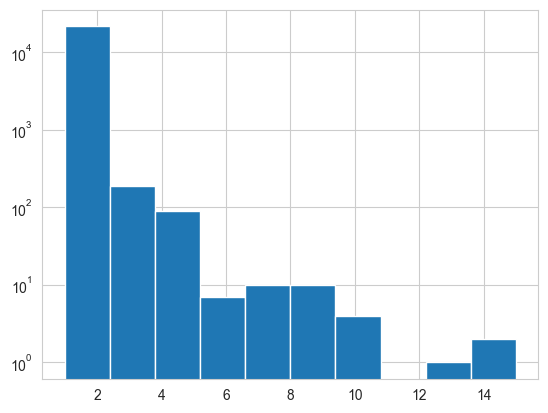

'Number of Unique Locus_Tag: 23852 | Number of Locus_Tag > 1: 0'
Locus_Tag
HCP21_00000020    1
HCP21_00159370    1
HCP21_00159460    1
HCP21_00159450    1
HCP21_00159440    1
                 ..
HCP21_00079720    1
HCP21_00079710    1
HCP21_00079700    1
HCP21_00079690    1
HCP21_00239090    1
Length: 23852, dtype: int64


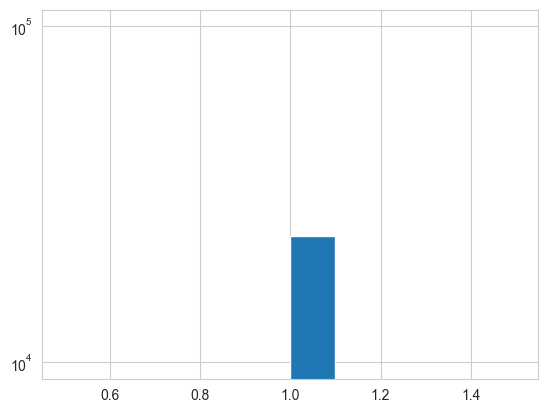

'Number of Unique Product: 1479 | Number of Product > 1: 632'
Product
hypothetical protein                                                        13938
Protein kinase domain.                                                        611
MORN repeat.                                                                  381
Serine/threonine protein kinase                                               273
Ras family.                                                                   186
                                                                            ...  
Periplasmic protein TonB, links inner and outer membranes                       1
Phage QLRG family, putative DNA packaging.                                      1
Phage shock protein A (IM30), suppresses sigma54-dependent transcription        1
Phosphatidylinositol-specific phospholipase C, X domain.                        1
von Willebrand factor type A domain.                                            1
Length: 1479, dtype: int64


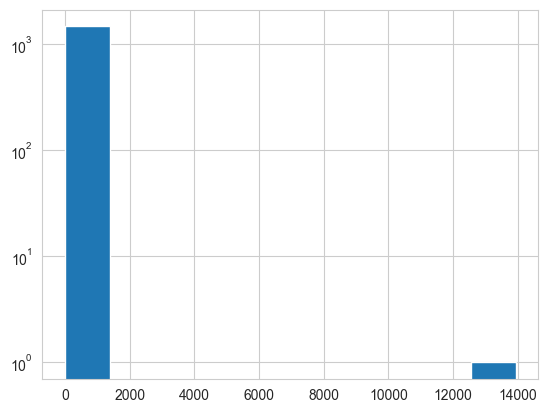

In [40]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Exploring Crop Microbiome Data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Group by these features to see if there is any possible analsysis to be done
for feature in ['Contig', 'Locus_Tag', 'Product']:
    
    # Group the dataframe by the column to see how many entries share the same feature
    feature_groups = microbiome_df.groupby(feature)
    
    # To display the number of entries per feature, size() is used on the groupby object
    feature_counts = feature_groups.size()
    
    # Sort the feature counts by their size in descending order
    sorted_feature_counts = feature_counts.sort_values(ascending=False)
    
    # Print some Metadata to understand the ratio
    print(f"Number of Unique {feature}: {len(sorted_feature_counts)} | Number of {feature} > 1: {(sorted_feature_counts > 2).sum()}")

    # Display a Histogram of the Feature Count
    feature_histogram = feature_counts.hist(log=True)
    # Print the Sorted Feature Counts
    print(sorted_feature_counts)

    # Use plt.show() to display the plot
    plt.show()
    
    # Close the plot
    plt.close()

In [41]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Define Adjusted Operon Detection Function per Contig
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Wrapper Function for the Original Predict_Operons function to Apply per Contig
def predict_operons_contig_based(
        df,
        contig_column='Contig',
        direction_column='Strand',
        pos_start_column='Pos_Start',
        pos_end_column='Pos_End',
        within_operon_dist=50,
        operon_prediction_output_column='Predicted_Operon'
):
    final_operon_df = pd.DataFrame()

    # Iterate through each unique contig
    for contig in df[contig_column].unique():
        contig_df = df[df[contig_column] == contig]

        # Ensure there are genes in the contig to process
        if contig_df.empty:
            continue

        # Create a contig-specific prefix
        contig_label = str(contig) + '-' 

        # Update kwargs to pass the modified operon prefix
        kwargs = {
            'direction_column': direction_column,
            'pos_start_column': pos_start_column,
            'pos_end_column': pos_end_column,
            'within_operon_dist': within_operon_dist,
            'operon_prediction_output_column': operon_prediction_output_column,
            'operon_label': contig_label
        }

        # Call the original predict_operons function for each contig
        operon_df = predict_operons(contig_df, **kwargs)

        # Append the results to the final dataframe
        final_operon_df = pd.concat([final_operon_df, operon_df], ignore_index=True)

    return final_operon_df

In [42]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Apply Operon Detection Function to Crop Microbiome DF
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Apply the Operon Detection Function to the original Dataframe
microbiome_operon_final_df = predict_operons_contig_based(microbiome_df, contig_column='Contig') 

# Create a condensed dataframe for viewing
microbiome_operon_df = microbiome_operon_final_df.copy()[['Contig','Predicted_Operon','Strand','Pos_Start','Pos_End']]

# View the Final Dataframe
Jio.print_df(microbiome_operon_df, df_name='Predicted Crop Microbiome Operons')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Predicted Crop Microbiome Operons: 23908 Row x 5 Col
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        Contig Predicted_Operon Strand  Pos_Start  Pos_End
0   HCP21_748_    HCP21_748_-R1      -          3      146
1   HCP21_5716    HCP21_5716-R1      -         41      313
2   HCP21_5491    HCP21_5491-R1      -        232      309
3   HCP21_5089    HCP21_5089-F1      +         81      530
4   HCP21_5196    HCP21_5196-F1      +          1      312
5   HCP21_6312    HCP21_6312-R1      -         89      592
6  HCP21_10684   HCP21_10684-F1      +         77      361
7   HCP21_9072    HCP21_9072-F1      +          3      320
8   HCP21_3159    HCP21_3159-R1      -         58      879
9   HCP21_3188    HCP21_3188-F1      +         19      474
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [43]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Save the Outputs of the Operon Prediction Operations
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
if save_file:

    # Save each Bacteria DF as a file
    for bacteria,bacteria_operon_df in bacteria_operon_final_dfs.items():
        
        # Save each DF as a File
        Jio.df_to_file(
            df=bacteria_operon_df, 
            file_name=f"PredictedOperons_{bacteria}", 
            file_format=output_format
        )
    
    # Save the Crop Microbiome DF as a File
    Jio.df_to_file(
        df=microbiome_operon_final_df,
        file_name=f"PredictedOperons_Crop_Microbiome",
        file_format=output_format
    )

In [44]:
# ~~~~~~~~~~~~~~~
#  End of Script
# ~~~~~~~~~~~~~~~
